In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

import time 
import numpy as np

import serial
import serial.tools.list_ports

import bokeh.plotting 
import bokeh.io 
bokeh.io.output_notebook()

Loading BokehJS ...

In [214]:
HANDSHAKE = 0
VOLTAGE_REQUEST = 1
ON_REQUEST = 2
STREAM = 3
READ_DAQ_DELAY = 4

def find_arduino(port=None):
    """Get the name of the port that is connected to Arduino."""
    if port is None:
        ports = serial.tools.list_ports.comports()
        port = '/dev/cu.SLAB_USBtoUART'
    return port


def handshake_arduino(
    arduino, sleep_time=1, print_handshake_message=False, handshake_code=0
):
    """Make sure connection is established by sending
    and receiving bytes."""
    # Close and reopen
    arduino.close()
    arduino.open()

    # Chill out while everything gets set
    time.sleep(sleep_time)

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()
    time.sleep(sleep_time)

    # Send request to Arduino
    arduino.write(bytes([handshake_code]))
    #print(bytes([handshake_code]))

    # Read in what Arduino sent
    handshake_message = arduino.read_until()
    #print(handshake_message)

    # Send and receive request again
    arduino.write(bytes([handshake_code]))
    #time.sleep(sleep_time)
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout

def parse_raw(raw):
    """Parse bytes output from Arduino."""
    
    raw = raw.decode()
    
    if raw[-1] != "\n":
        print("Input must end with newline, otherwise message is incomplete.")
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )
        

    t, Pa = raw.rstrip().split(",")

    return int(t), float(Pa)

In [210]:
def daq_stream(arduino, n_data=100, delay=20):
    """Obtain `n_data` data points from an Arduino stream
    with a delay of `delay` milliseconds between each."""
    # Specify delay
    print(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())
    arduino.write(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())

    # Initialize output
    time_ms = np.empty(n_data)
    voltage = np.empty(n_data)

    # Turn on the stream
    arduino.write(bytes([STREAM]))

    # Receive data
    i = 0
    while i < n_data:
        raw = arduino.read_until()

        try:
            t, V = parse_raw(raw)
            if V > 80000:
                time_ms[i] = t
                voltage[i] = V
                i += 1
        except:
            print("Exception triggered")
            pass

    # Turn off the stream
    arduino.write(bytes([ON_REQUEST]))

    return pd.DataFrame({'time (ms)': time_ms, 'voltage (V)': voltage})

In [208]:
port = find_arduino()
arduino = serial.Serial(port, baudrate=115200)
arduino.setDTR(False)
arduino.setRTS(False)

In [215]:


handshake_arduino(arduino, handshake_code=HANDSHAKE, print_handshake_message=True)
df = daq_stream(arduino, n_data=100, delay=20)

Handshake message: Message received.

b'\x0420x'


In [ ]:
plt.figure(figsize=(12, 6))#size of the data plot



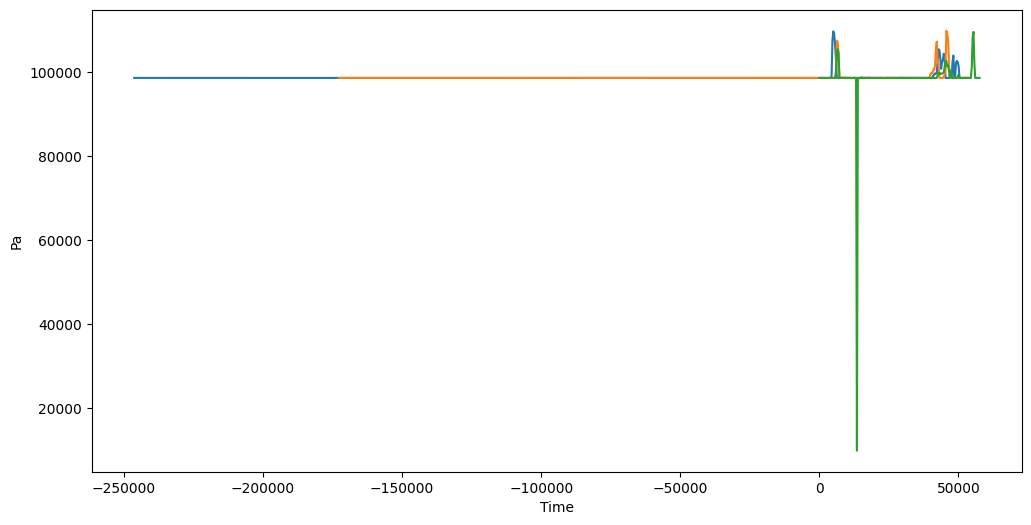

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

def read_and_plot(filepaths):
    basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'
    plt.figure(figsize=(12, 6))#size of the data plot

    for filepath in filepaths:
        filepath = basepath + filepath
        if not os.path.isfile(filepath):
            print(f"{filepath} not working.")
            continue

        # reads all the data into the data frame along with all the varaiables
        column_names = [
            "Time", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "Pa", "PSI", "atm"
        ]
        data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels

        #will basically equalize the time
        data["Time"] = data["Time"] - data["Time"].iloc[0]

        # will plot all the points
        # plt.plot(data["Time"], data["Pa"], label=os.path.basename(filepath))
        sns.lineplot(data=data, x=data["Time"], y=data["Pa"])

    # plt.xlabel('Time')
    # plt.ylabel('Pressure (Pa)')
    # plt.title('Pressure over Time')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

if __name__ == "__main__":
    #filepaths = ["bt1.csv", "bt2.csv", "bt3.csv"]
    filepaths = ["bend3.csv", "bend2.csv", "bend1.csv"] #all the files i want in the graph
    read_and_plot(filepaths)